In [1]:
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
from skimage.measure import block_reduce # pip install scikit-image
import mpl_scatter_density
import glob, os, time
from torch.utils.data import Dataset, ConcatDataset, DataLoader, sampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import roc_curve, auc
from utils import *
import warnings
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(0)

Welcome to JupyROOT 6.24/02


In [2]:
figOutDir = './PLOTS/3_Anomaly_Validation_NoCorrection_EE-/'
os.system('mkdir -p {}'.format(figOutDir))

0

### Get Data

In [3]:
# Import data

files = glob.glob('../DATA/500ev_EE_ECALDQM_*.parquet')
print('Total number of parquet files: {}'.format(len(files)))
#f = [pq.ParquetFile(i) for i in files]

print('\nError reading the file below: ')
f = []
for i in range(len(files)):
    try:
        f.append(pq.ParquetFile(files[i]))
    except:
        print(files[i])
        files[i] = None
files.remove(None)

nEntries = [i.num_row_groups for i in f] 

Total number of parquet files: 240

Error reading the file below: 
../DATA/500ev_EE_ECALDQM_run316766.parquet


In [4]:
class ParquetDataset(Dataset):
    def __init__(self, file):
        self.parquet = pq.ParquetFile(file)
        self.cols = ['PU', 'lumi', 'EEOccupancyTask_EEOT_digi_occupancy_EE_m.list.item.list.item', 'EEOccupancyTask_EEOT_digi_occupancy_EE_p.list.item.list.item']
    def __getitem__(self, index):
        data = dict([])
        for key in self.cols:
            key = key.split('.')[0]
            try:
                data[key] = np.float64(self.parquet.read_row_groups(index, columns=[key]).to_pydict()[key])
            except:
                data[key] = np.float64(self.parquet.read_row_group(index, columns=[key]).to_pydict()[key])
        return data
    def __len__(self):
        return self.parquet.num_row_groups

In [5]:
datasetAll = ConcatDataset([ParquetDataset(f) for f in files])

In [6]:
# GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Functions: Plot Images, Apply PU Correction, Apply Fake Anomalies, Add Padding around the Images

In [7]:
# 2D img plot
def plot_2D(img, title = '', doColorbar=True, doLog=False, label='', xlabel='ix', ylabel='iy', vmax=0, doTick=True, doSave=False, figName='plot'):
    fig, ax = plt.subplots()

    cmap = plt.cm.get_cmap('jet')
    cmap.set_bad(color='black')
    cmap.set_under(color='lime')
    cmap.set_over(color='red')
    
    ax.imshow(np.zeros_like(img), origin='lower', cmap=cmap)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if doLog:
        im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap, vmax=vmax)
    else:
        im = ax.imshow(img, origin='lower', cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', cmap=cmap, vmax=vmax)

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.015, label=label)
    else:
        im = ax.imshow(img, origin='lower', cmap=cmap, vmin = 0.5, vmax = 0.9)
        
    off = 0.5
    
    if doTick:
        ax.set_xticks(np.arange(0,22,2)-off)
        ax.set_yticks(np.arange(0,22,2)-off)

        ax.set_xticklabels(np.arange(0,22,2))
        ax.set_yticklabels(np.arange(0,22,2))
    
    # HORIZONTAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = 0, 20
        y1, y2 = i, i
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')
    # VERTICAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = i, i
        y1, y2 = 0, 20
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')

    
    # labels
    plt.xlabel(xlabel, size=11)
    plt.ylabel(ylabel, size=11)
    plt.title(title, fontsize=13)
    
    if doSave:
        plt.savefig('{}.png'.format(figName))
    
    plt.show()

In [8]:
# Linear regression on Total Occupancy vs. PU

# Apply PU correction to occupancy maps for all LS
# Then multiply by # of towers (20x20) to make the mean occupancy across the pixels 1.

def applyPUcorr(img, PU, fit):
    scale = fit[0]*PU+fit[1]

    # reshape the `scale` tensor if necessary to perform division with `img` tensor, to match the dimensions
    # -> if the img tensor has the size of e.g. [batch_size, 1, 20, 20] whereas PU has the size [batch_size, 1],
    # -> you need to reshape the PU tensor as [batch_size, 1, 1, 1] by adding the extra 2 dimensions
    # -> but if img and PU tensor have the same shape, you don't add any extra dimensions
    scaleShape = list(scale.shape)
    extraDim = [1]*(len(img.shape)-len(PU.shape)) # additional dimensions
    scaleShape += extraDim
    
    scale = scale.reshape(torch.Size(scaleShape))
    
    corrected = img / scale

    return 20*20*corrected

In [9]:
def generateFakeAnomCoord(validIndex, nCoord):
    np.random.seed(0)
    fakeIndex = np.random.randint(0, len(validIndex), size=nCoord) # nCoord == batch_size * (# of batches)
    fakeCoord = [validIndex[i] for i in fakeIndex]
    
    return fakeCoord

def applyFakeAnomaly(img, fakeIndex, anomValue=0):
    if len(fakeIndex) == 2:
        nAnomForLS = int(img.shape[0]) - int(torch.count_nonzero(img[range(img.shape[0]), :, fakeIndex[0], fakeIndex[1]]))
        if nAnomForLS != 0:
            print('Already dead '*nAnomForLS)
        
        img[range(img.shape[0]), :, fakeIndex[0], fakeIndex[1]] = anomValue
    # img has the shape of (N of images, N of layers, rows, cols)
    else:
        fakeIndex = torch.tensor(fakeIndex)
        fakeRows = fakeIndex[:,0]  # extract list of rows
        fakeCols = fakeIndex[:,1]  # extract list of cols

        nAnomForLS = int(img.shape[0]) - int(torch.count_nonzero(img[range(img.shape[0]), :, fakeRows, fakeCols]))
        if nAnomForLS != 0:
            print('Already dead '*nAnomForLS)

        img[range(img.shape[0]), :, fakeRows, fakeCols] = anomValue
        
    return img

In [10]:
def addPadding(img):
    if len(img.shape) == 2:
        pad_top = torch.unsqueeze(img[img.shape[1]-1,:],0)
        img = torch.cat((img, pad_top), 0)
        #plot_2D(img)

        pad_bottom = torch.unsqueeze(img[0,:],0)
        img = torch.cat((pad_bottom, img), 0)
        #plot_2D(img)

        pad_left = torch.unsqueeze(img[:,0], 1)
        img = torch.cat((pad_left, img), 1)
        #plot_2D(img)

        pad_right = torch.unsqueeze(img[:,img.shape[1]-1], 1)
        img = torch.cat((img, pad_right), 1)
        #plot_2D(img.detach().cpu())
        
    elif len(img.shape) == 4:
        pad_top = torch.unsqueeze(img[:,:,img.shape[2]-1,:],2)
        img = torch.cat((img, pad_top), 2)
        #plot_2D(img[10][0].detach().cpu())
        
        pad_bottom = torch.unsqueeze(img[:,:,0,:],2)
        img = torch.cat((pad_bottom, img), 2)
        #plot_2D(img[10][0].detach().cpu())
           
        pad_left = torch.unsqueeze(img[:,:,:,0], 3)
        img = torch.cat((pad_left, img), 3)
        #plot_2D(img[10][0].detach().cpu())
        
        pad_right = torch.unsqueeze(img[:,:,:,img.shape[3]-1], 3)
        img = torch.cat((img, pad_right), 3)
        #plot_2D(img[10][0].detach().cpu())
        
    return img

### Import: Average Occupancy Map, Valid Tower List, PU Fit Parameters

In [11]:
avg_occ_dir = './Avg_Occupancy/'
avg_occupancy = {'p': np.loadtxt('{}avg_occupancy_EEp.csv'.format(avg_occ_dir), delimiter=','), 'm': np.loadtxt('{}avg_occupancy_EEm.csv'.format(avg_occ_dir), delimiter=',')}

In [12]:
valid_tower_dir = './Valid_Tower_List/'
validIndex = {'p': list(np.loadtxt('{}valid_towers_EEp.csv'.format(valid_tower_dir), delimiter=',').astype(int)), 'm': list(np.loadtxt('{}valid_towers_EEm.csv'.format(valid_tower_dir), delimiter=',').astype(int))}

validIndex['p'] = [ idx.tolist() for idx in validIndex['p']]
validIndex['m'] = [ idx.tolist() for idx in validIndex['m']]

validIndex['p'].remove([7,0])

In [13]:
PUdir = './PU_Correction/'
fit = {'p': np.loadtxt('{}EEp_PU_Correction_Factor.csv'.format(PUdir), delimiter=','), 'm': np.loadtxt('{}EEm_PU_Correction_Factor.csv'.format(PUdir), delimiter=',')} # fit parameters for EE+(p) and EE-(m)

### ML: Model Class

In [14]:
doPadding = True

In [15]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.LeakyReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

In [16]:
if doPadding:
    layer0_kernel = 3
    layer2_shape = 10
    final_shape = 22
else:
    layer0_kernel = 5
    layer2_shape = 8
    final_shape = 20

class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=layer0_kernel, stride=1, padding=(0,0)), nn.LeakyReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*int(layer2_shape/2)*int(layer2_shape/2))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(layer2_shape, layer2_shape))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=layer0_kernel, stride=1, padding=(0,0))
        self.dconv0_relu = nn.LeakyReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)

    '''
    For VAE:
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    '''

    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size(), 'input')
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size(), 'econv0')
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size(), 'maxpool')

        x = self.elayer1(x)
        if self.debug: print(x.size(), 'elayer1')
        x = self.elayer2(x)
        if self.debug: print(x.size(), 'elayer2')
        x = self.elayer3(x)
        if self.debug: print(x.size(), 'elayer3')
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Bottleneck")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        if self.debug: print(x.size(), 'GlobalMaxPool')
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size(), 'flatten')
        
        '''
        For VAE:
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        '''
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        if self.debug: print("Expand bottleneck")
        x = self.fc(x) # expand
        if self.debug: print(x.size(), 'FC-upsample')
        x = x.view(-1, self.fmaps[1], int(layer2_shape/2), int(layer2_shape/2))
        if self.debug: print(x.size(), 'reshape')
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer3(x)
        if self.debug: print(x.size(), 'dlayer3')
        x = self.dlayer2(x)
        if self.debug: print(x.size(), 'dlayer2')
        x = self.dlayer1(x)
        if self.debug: print(x.size(), 'dlayer1')
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size(), "interp")
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, final_shape, final_shape)) 
        if self.debug: print(x.size(), 'dconv0')
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

### ML Functions: Evalulate during Validation, Calculate FDR

In [23]:
def do_eval(ae, loader, epoch, doPadding=False, isDead=False, isHot=False, fakeIndices=[], avg_occ=[]):
    loss_ = []

    for i, data in enumerate(loader):
        X, PU = data['EEOccupancyTask_EEOT_digi_occupancy_EE_{}'.format(EE)].to(device), data['PU'].to(device)
        
        # PU Correction
        X = applyPUcorr(X, PU, fit[EE]).float()
        
        # Fake anomaly value
        if isDead or isHot:
            if isDead:
                anomValue = 0
            elif isHot:
                f = 0.2

                hotValue = torch.tensor([25*500*f]*batch_size).to(device)
                hotValue = torch.unsqueeze(hotValue, 1)

                hotValue = applyPUcorr(hotValue, PU, fit[EE]).float()

                hotValue[hotValue > 8.] = 8. # upperbound cutoff

                anomValue = hotValue
                
            fakeIndex = fakeIndices[i*batch_size:(i+1)*batch_size]
        
            # Apply Fake Anomaly
            X = applyFakeAnomaly(X, fakeIndex, anomValue)
        
        # Padding
        if doPadding:
            X = addPadding(X)
            #plot_2D(X[0][0][1:21,1:21].detach().cpu().numpy(), label='Normalized Occupancy')
        
        # Feed to AE
        Xreco = ae(X)
        #plot_2D(Xreco[0][0][1:21,1:21].detach().cpu().numpy(), label='Normalized Occupancy')
        
        # Calculate loss
        losses = F.mse_loss(Xreco.float(), X.float(), reduction='none')
        
        # Process loss maps into good and anom losses
        
        # Padding
        if doPadding:
            losses = losses[:,:,1:21,1:21]
            
            #plot_2D(losses[0][0].detach().cpu().numpy(), doColorbar=False)
            #break

        # Get losses of anomalous for anomaly validation and of good towers for good validation
            if isDead or isHot:
                fakeIndex = torch.tensor(fakeIndex)
                fakeRows = fakeIndex[:,0]  # extract list of rows
                fakeCols = fakeIndex[:,1]  # extract list of cols
                anom_losses = losses[range(losses.shape[0]), :, fakeRows, fakeCols]

                loss_.append(anom_losses.tolist())

            else:
                validTowers = torch.tensor(validIndex[EE])
                good_losses = losses[:, :, validTowers[:,0], validTowers[:,1]]
                
                loss_.append(good_losses.tolist())  
            

        # For last epoch: get anomaly losses to make average loss map for anomaly scenario
        if epoch == 33: # best epoch out of 50
            avg_occ_map['input'].append(X[:,0,1:21,1:21].detach().cpu().numpy())
            avg_occ_map['reco'].append(Xreco[:,0,1:21,1:21].detach().cpu().numpy())  
            
            if isDead:
                dead_index = anom_losses.nonzero()[:,0]

                for index in dead_index:
                    dead_loss_epoch50['index'].append(fakeIndex[index].detach().cpu().numpy())
                    dead_loss_epoch50['loss'].append(anom_losses[index].detach().cpu().numpy())
                    
                dead_low_loss = anom_losses < 0.2
                if len(dead_low_loss.nonzero()) > 0:
                    dead_low_index = dead_low_loss.nonzero()[:,0]

                    for index in dead_low_index:
                        low_dead_loss_index['index'].append(fakeIndex[index])
                        low_dead_loss_index['loss'].append(anom_losses[index].detach().cpu().numpy())
                    
            elif isHot:
                hot_index = anom_losses.nonzero()[:,0]

                for index in hot_index:
                    hot_loss_epoch50['index'].append(fakeIndex[index].detach().cpu().numpy())
                    hot_loss_epoch50['loss'].append(anom_losses[index].detach().cpu().numpy())
                    
                hot_low_loss = anom_losses < 10.
                if len(hot_low_loss.nonzero()) > 0:
                    hot_low_index = hot_low_loss.nonzero()[:,0]

                    for index in hot_low_index:
                        low_hot_loss_index['index'].append(fakeIndex[index])
                        low_hot_loss_index['loss'].append(anom_losses[index].detach().cpu().numpy())
                    
                
    # Append losses to list
    if isDead:
        loss_ = np.concatenate(loss_)
        val_dead_loss.append(loss_)
        print('\nEpoch {} > Dead Val loss: {:.4f}'.format(epoch, loss_.mean()))
    elif isHot:
        loss_ = np.concatenate(loss_)
        val_hot_loss.append(loss_)
        print('\nEpoch {} > Hot (f={}) Val loss: {:.4f}'.format(epoch, f, loss_.mean()))
    else:
        loss_ = np.concatenate(loss_)
        val_good_loss.append(loss_)
        print('\nEpoch {} > Good Val loss: {:.4f}'.format(epoch, loss_.mean()))
    
    return loss_

In [24]:
def get_roc(loss_maps, loss_map_anoms):
    anom_map=loss_map_anoms
    norm_map=loss_maps
   
    anom_thres=np.percentile(anom_map,1)
    
    print('Anomaly threshold = %.4f'%(anom_thres))
    
    FP = len(norm_map[norm_map > anom_thres])
    TP = len(anom_map[anom_map > anom_thres])
    
    FN = len(anom_map[anom_map < anom_thres])
    TN = len(norm_map[norm_map < anom_thres])
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)
    
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    
    FDR = FP/(FP+TP)
    
    #print('TPR = {:.4f}'.format(TPR))
    
    print('FDR = {:.4f}'.format(FDR))
    
    return FDR, anom_thres

### Validation (No Correction): EE-

In [25]:
# Split into training and validation set
n_train = int(0.7*len(datasetAll))
n_val = len(datasetAll) - n_train
idxs = np.random.permutation(len(datasetAll))
#idxs = range(len(dataset))
idxs_train, idxs_val = idxs[:n_train], idxs[-n_val:]

batch_size = 32

# For training: use 70% of the dataset, shuffle at every epoch, batch size of 32
train_sampler = sampler.SubsetRandomSampler(idxs_train)
train_loader = DataLoader(dataset=datasetAll, batch_size=32, num_workers=10, sampler=train_sampler, pin_memory=True, drop_last=True)

# For validation: use 30% of the dataset, no shuffle so to compare the same image from epoch to epoch, batch size of 32
val_sampler = sampler.SequentialSampler(idxs_val)
val_loader = DataLoader(dataset=datasetAll, batch_size=batch_size, num_workers=10, sampler=val_sampler, pin_memory=True, drop_last=True)

In [26]:
EE = 'm'
modelDir = './MODELS/EE{}/'.format(EE)

epochs = 50 # Total number of epochs trained

In [27]:
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader))

In [28]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

avg_occ_map = {'input': [], 'reco': []}

dead_loss_epoch50 = {'index': [], 'loss': []}
hot_loss_epoch50 = {'index': [], 'loss': []}

low_dead_loss_index = {'index': [], 'loss': []}
low_hot_loss_index = {'index': [], 'loss': []}

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

for e in range(epochs):
    epoch = e+1

    # Run Validation
    model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
    model.eval()
    print("\n>> Validation (No Correction): Good samples <<<<<<<<")
    good_losses = do_eval(model, val_loader, epoch, doPadding=doPadding, isDead=False, isHot=False)

    # Calculate FDR for Dead tower 
    print("\n>> Validation (No Correction): Dead Tower samples <<<<<<<<")
    dead_losses = do_eval(model, val_loader, epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices)

    FDR, anom_thres = get_roc(good_losses, dead_losses)
    FDRs['dead'].append(FDR)
    all_anom_thres['dead'].append(anom_thres)

    # Calculate FDR for Hot tower 
    print("\n>> Validation (No Correction): Hot Tower samples <<<<<<<<")
    hot_losses = do_eval(model, val_loader, epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices)

    FDR, anom_thres = get_roc(good_losses, hot_losses)
    FDRs['hot'].append(FDR)
    all_anom_thres['hot'].append(anom_thres)

    #print('\nFDR')
    #print(FDRs)
    #print('\nAnomaly Threshold')
    #print(all_anom_thres)


>> Validation (No Correction): Good samples <<<<<<<<

Epoch 1 > Good Val loss: 0.0320

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 1 > Dead Val loss: 1.7449
Anomaly threshold = 0.1326
FDR = 0.9356

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 1 > Hot (f=0.2) Val loss: 33.9339
Anomaly threshold = 11.8859
FDR = 0.0000

>> Validation (No Correction): Good samples <<<<<<<<

Epoch 2 > Good Val loss: 0.0294

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 2 > Dead Val loss: 1.5802
Anomaly threshold = 0.1365
FDR = 0.9220

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 2 > Hot (f=0.2) V

FDR = 0.8845

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 16 > Hot (f=0.2) Val loss: 31.8555
Anomaly threshold = 10.6140
FDR = 0.0000

>> Validation (No Correction): Good samples <<<<<<<<

Epoch 17 > Good Val loss: 0.0269

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 17 > Dead Val loss: 1.6169
Anomaly threshold = 0.1515
FDR = 0.8820

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 17 > Hot (f=0.2) Val loss: 31.8998
Anomaly threshold = 10.7174
FDR = 0.0000

>> Validation (No Correction): Good samples <<<<<<<<

Epoch 18 > Good Val loss: 0.0270

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dea


Epoch 32 > Good Val loss: 0.0269

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 32 > Dead Val loss: 1.6003
Anomaly threshold = 0.1440
FDR = 0.8935

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 32 > Hot (f=0.2) Val loss: 32.1053
Anomaly threshold = 10.6481
FDR = 0.0000

>> Validation (No Correction): Good samples <<<<<<<<

Epoch 33 > Good Val loss: 0.0268

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 33 > Dead Val loss: 1.6448
Anomaly threshold = 0.1594
FDR = 0.8673

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 33 > Hot (f=0.2) Val loss: 31.6521
Anomaly threshold = 10.7470
FDR

Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 47 > Hot (f=0.2) Val loss: 31.8365
Anomaly threshold = 10.7048
FDR = 0.0000

>> Validation (No Correction): Good samples <<<<<<<<

Epoch 48 > Good Val loss: 0.0270

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 48 > Dead Val loss: 1.6258
Anomaly threshold = 0.1522
FDR = 0.8826

>> Validation (No Correction): Hot Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 48 > Hot (f=0.2) Val loss: 31.1389
Anomaly threshold = 10.4971
FDR = 0.0000

>> Validation (No Correction): Good samples <<<<<<<<

Epoch 49 > Good Val loss: 0.0266

>> Validation (No Correction): Dead Tower samples <<<<<<<<
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 
Already dead 

Epoch 49 > Dead Val loss: 1.6208
Anomaly threshold = 0.1589
FDR = 0.

In [30]:
avg_occ_input = np.array([[0.]*20]*20)
avg_occ_reco = np.array([[0.]*20]*20)

for i in range(len(avg_occ_map['input'])):
    for j in range(32):
        avg_occ_input += avg_occ_map['input'][i][j]
        avg_occ_reco += avg_occ_map['reco'][i][j]

avg_occ_input /= (32*len(avg_occ_map['input']))
avg_occ_reco /= (32*len(avg_occ_map['reco']))

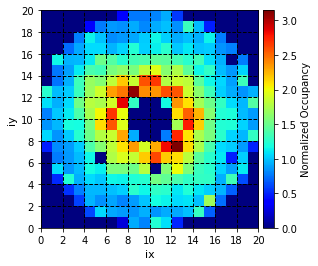

In [31]:
plot_2D(avg_occ_input, label='Normalized Occupancy')

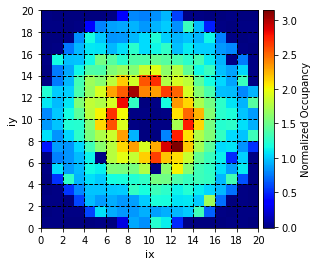

In [32]:
plot_2D(avg_occ_reco, label='Normalized Occupancy')

### Plot Low Losses, Average Loss Map for Dead and Hot Tower Scenario (at Last Epoch)

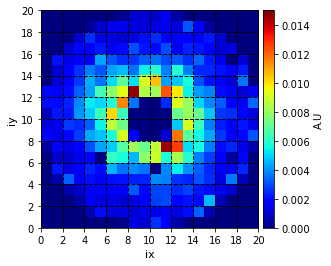

In [33]:
dead_loss_avg = np.array([[0.]*20]*20)

for i, index in enumerate(dead_loss_epoch50['index']):
    index = index.tolist()
    dead_loss_avg[index[0]][index[1]] += dead_loss_epoch50['loss'][i]

dead_loss_avg /= np.sum(dead_loss_avg)

plot_2D(dead_loss_avg, label='A.U', vmax=0.015)
#plot_2D(dead_loss_avg, title='EE{}: Dead Tower Loss Average'.format(EE), label='A.U', doSave=True, figName='{}/DeadTower_Avg_Loss_EE{}.png'.format(figOutDir, EE))

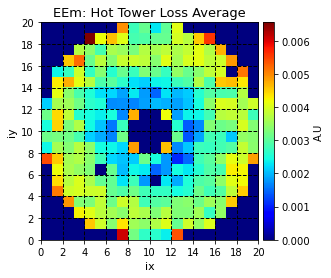

In [34]:
hot_loss_avg = np.array([[0.]*20]*20)

for i, index in enumerate(hot_loss_epoch50['index']):
    index = index.tolist()
    hot_loss_avg[index[0]][index[1]] += hot_loss_epoch50['loss'][i]

hot_loss_avg /= np.sum(hot_loss_avg)

plot_2D(hot_loss_avg, title='EE{}: Hot Tower Loss Average'.format(EE), label='A.U', doSave=True, figName='{}/HotTower_Avg_Loss_EE{}.png'.format(figOutDir, EE))

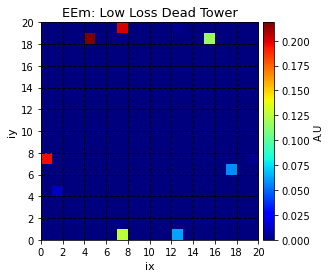

In [35]:
dead_low_loss = np.array([[0.]*20]*20)

for i, index in enumerate(low_dead_loss_index['index']):
    index = index.tolist()
    dead_low_loss[index[0]][index[1]] += low_dead_loss_index['loss'][i]

dead_low_loss /= np.sum(dead_low_loss)

plot_2D(dead_low_loss, title='EE{}: Low Loss Dead Tower'.format(EE), label='A.U', doSave=True, figName='{}/DeadTower_Low_Loss_EE{}.png'.format(figOutDir, EE))

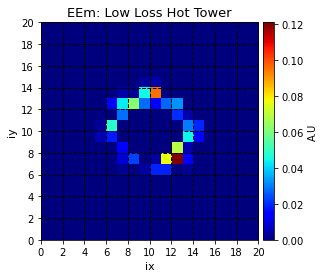

In [36]:
hot_low_loss = np.array([[0.]*20]*20)

for i, index in enumerate(low_hot_loss_index['index']):
    index = index.tolist()
    hot_low_loss[index[0]][index[1]] += low_hot_loss_index['loss'][i]

hot_low_loss /= np.sum(hot_low_loss)

plot_2D(hot_low_loss, title='EE{}: Low Loss Hot Tower'.format(EE), label='A.U', doSave=True, figName='{}/HotTower_Low_Loss_EE{}.png'.format(figOutDir, EE))

### Find Best Epoch based on FDR, Plot Loss Histogram with Anomaly Threshold

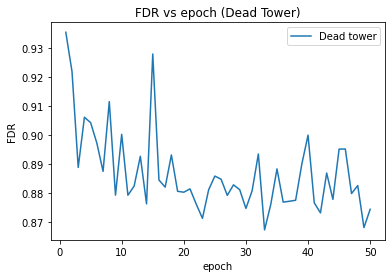

In [37]:
# FDR vs epoch (Dead Tower)
plt.plot(range(1, epochs+1), FDRs['dead'], label='Dead tower')
plt.xlabel('epoch')
plt.ylabel('FDR')
plt.legend()
plt.title('FDR vs epoch (Dead Tower)')

plt.savefig('{}/FDR_vs_Epoch_DeadTower_EE{}.png'.format(figOutDir, EE))

plt.show()

In [38]:
# Find the lowest FDR from all epochs
best_epoch_idx = {'dead': 0, 'hot': 0}
best_FDR = {'dead': 0, 'hot': 0}
thres = {'dead': 0, 'hot': 0}

best_epoch_idx['dead'] = FDRs['dead'].index(min(FDRs['dead']))
best_FDR['dead'] = FDRs['dead'][best_epoch_idx['dead']]
thres['dead'] = all_anom_thres['dead'][best_epoch_idx['dead']]

print('Dead Tower')
print('Best FDR of {:.4f} at epoch {}'.format(best_FDR['dead'], best_epoch_idx['dead']+1))
print('Corresponding Anomaly Threshold = {:.4f}'.format(thres['dead']))

Dead Tower
Best FDR of 0.8673 at epoch 33
Corresponding Anomaly Threshold = 0.1594


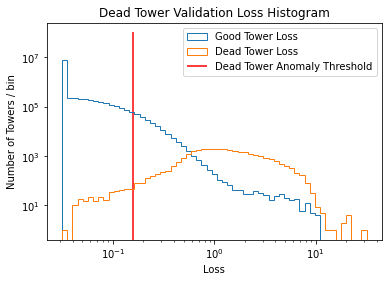

In [39]:
# Histogram of dead tower losses for its best FDR epoch
bins = np.logspace(-1.5, 1.5, int((1.5+1.5)*20))

plt.hist(np.clip(np.array(val_good_loss[best_epoch_idx['dead']]).ravel(), bins[0], bins[-1]), bins=bins, histtype='step',range=(0, 1e3), label='Good Tower Loss')
plt.hist(np.clip(np.array(val_dead_loss[best_epoch_idx['dead']]).ravel(), bins[0], bins[-1]), bins=bins, histtype='step',range=(0, 1e3), label='Dead Tower Loss')

plt.vlines(x=all_anom_thres['dead'][best_epoch_idx['dead']], ymin=0, ymax=1e8, color='red', label='Dead Tower Anomaly Threshold')

plt.legend()

plt.xlabel('Loss')
plt.ylabel('Number of Towers / bin')
plt.yscale('log')
plt.xscale('log')

plt.title('Dead Tower Validation Loss Histogram')
#plt.title('Dead Tower Validation Loss Histogram (at epoch {} with best FDR of {:.2f})'.format(best_epoch_idx['dead']+1, best_FDR['dead']))

plt.savefig('{}/DeadTower_Loss_EE{}_NoCorrection.png'.format(figOutDir, EE))

plt.show()

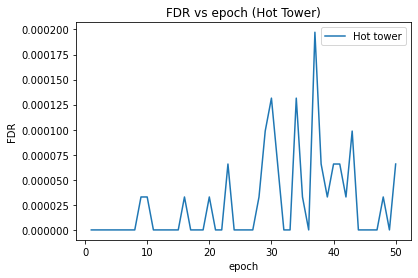

In [40]:
# FDR vs epoch (Hot Tower)
plt.plot(range(1, epochs+1), FDRs['hot'], label='Hot tower')
plt.xlabel('epoch')
plt.ylabel('FDR')
plt.legend()
plt.title('FDR vs epoch (Hot Tower)')

plt.savefig('{}/FDR_vs_Epoch_HotTower_EE{}.png'.format(figOutDir, EE))

plt.show()

In [41]:
# Find the lowest FDR from all epochs
best_epoch_idx['hot'] = FDRs['hot'].index(min(FDRs['hot']))
best_FDR['hot'] = FDRs['hot'][best_epoch_idx['hot']]
thres['hot'] = all_anom_thres['hot'][best_epoch_idx['hot']]

print('Hot Tower')
print('Best FDR of {:.4f} at epoch {}'.format(best_FDR['hot'], best_epoch_idx['hot']+1))
print('Corresponding Anomaly Threshold = {:.4f}'.format(thres['hot']))

Hot Tower
Best FDR of 0.0000 at epoch 1
Corresponding Anomaly Threshold = 11.8859


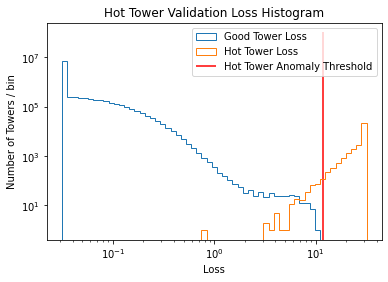

In [42]:
# Histogram of hot tower losses for its best FDR epoch
bins = np.logspace(-1.5, 1.5, int((1.5+1.5)*20))

plt.hist(np.clip(np.array(val_good_loss[best_epoch_idx['hot']]).ravel(), bins[0], bins[-1]), bins=bins, histtype='step',range=(0, 1e3), label='Good Tower Loss')
plt.hist(np.clip(np.array(val_hot_loss[best_epoch_idx['hot']]).ravel(), bins[0], bins[-1]), bins=bins, histtype='step',range=(0, 1e3), label='Hot Tower Loss')

plt.vlines(x=all_anom_thres['hot'][best_epoch_idx['hot']], ymin=0, ymax=1e8, color='red', label='Hot Tower Anomaly Threshold')

plt.legend()

plt.xlabel('Loss')
plt.ylabel('Number of Towers / bin')
plt.yscale('log')
plt.xscale('log')

plt.title('Hot Tower Validation Loss Histogram')
#plt.title('Hot Tower Validation Loss Histogram (at epoch {} with best FDR of {:.2f})'.format(best_epoch_idx['hot']+1, best_FDR['hot']))

plt.savefig('{}/HotTower_Loss_EE{}_NoCorrection.png'.format(figOutDir, EE))

plt.show()